# Background 

    Starting from any random Wikipedia page, following the first* page link of the current page will eventually lead you to the "Philosophy" page of Wikipedia (~95% of the time).
     
    * Due to the structure of Wikipedia articles, the first valid link must NOT:
        
        be in either parentheses (usually language pages) or italics (usually disambiguations)
        
        be a link to either a meta page, a page outside Wikipedia, or a broken link
        
        be an in-page citation
        
        
        

## Basic Goal

    Make a webcrawler that starts from a random Wikipedia page, and follows the first page link until it either finds the Philosophy page, a page with no links, or loops back to a previously visited link.
    
    Return the name of the starting page, and the degrees of separation from the Philosophy page (set degree to -1 if terminates otherwise)

        Ex. the page "Kevin Bacon" should have a degree of separation of 12
        
    NOTE: For crawling, use either the Wikipedia API or 
    
    
    You can start from a random Wikipedia page with a URL (https://en.wikipedia.org/wiki/Special:Random)   
    
   

## Tips

 
        
    Use a while-loop for the crawling, but add a maximum search number if you're still debugging it
    
    When searching for links, you're always looking at the main text of the page (use the HTML structure)
        
        
        
        

## Advanced Goals

    1.) Get the degrees of separation for 1000 random pages. Find the median degree of separation as well as the distribution.
    
    2.) Considering your results, and the size of the English Wikipedia, estimate how many pages there are of degree 6.
    
    3.) Try the Cebuano Wikipedia. Following the same rules above, determine the network structure. 
    Is there is a page that all others tend to lead back to? 
    Does it tend to loop more? 
    In any case, are the degrees generally shorter/longer?
    
        

In [7]:
import time
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

# Wikipedia Crawler

## Implementation for Single Link

In [4]:
def find_philosophy(
        start_url: str = "https://en.wikipedia.org/wiki/Special:Random",
        target_url: str = "https://en.wikipedia.org/wiki/Philosophy",
) -> Tuple[str, int]:
    
	next_url = start_url
	visited_urls = set()
	degrees = 0

	try:
		options = webdriver.ChromeOptions()
		options.add_argument("--headless")
		path = "/usr/local/bin/chromedriver"
		chrome_service = webdriver.ChromeService(executable_path=path)
		driver = webdriver.Chrome(service=chrome_service, options=options)
		driver.get(start_url)
		starting_title = driver.title

		while True:
			if next_url in visited_urls:
				degrees = -1
				print("Loop detected!")
				break

			if next_url == target_url:
				print("Philosophy has been reached!")
				break

			visited_urls.add(next_url)
			driver.get(next_url)

			try:
				main_content = driver.find_element("id", "mw-content-text")
				links = main_content.find_elements(By.CSS_SELECTOR, "div.mw-parser-output > p a")

				found_valid_link = False

				for link in links[:5]:
					href = link.get_attribute("href")
					if (
						href and "/wiki" in href and
						":" not in href.split("/wiki/")[-1] and
						"cite_note" not in href
					):
						next_url = href
						found_valid_link = True
						degrees +=1
						break

				if not found_valid_link:
					degrees = -1
					print("Invalid link!")
					break

			except NoSuchElementException:
				degrees = -1
				break

			time.sleep(0.5)

	finally:
		driver.quit()

	return (starting_title, degrees)

In [5]:
results = find_philosophy(start_url="https://en.wikipedia.org/wiki/Kevin_Bacon")
results

Philosophy has been reached!


('Kevin Bacon - Wikipedia', 13)

## Implementation for 1000 Pages

### Median degree of separation and distribution

In [6]:
pages = {}

for i in range(3):
    if i % 10 == 0:
        print(f"Processing page {i}/1000...")
    key, value = find_philosophy()
    pages[key] = value

Processing page 0/1000...
Philosophy has been reached!
Philosophy has been reached!
Philosophy has been reached!


In [7]:
df = pd.DataFrame(list(pages.items()), columns=['first_page', 'degrees'])
df

,first_page,degrees
0,Harry S. Truman Historic District - Wikipedia,17
1,Walks of Life - Wikipedia,25
2,Ivan Kirev - Wikipedia,8


In [3]:
df = pd.read_csv("/Users/katecastillo/Documents/MSDS/wikipedia-crawler/results_20241027-050554.csv")
df

,first_page,degrees
0,Susanna Wesley - Wikipedia,9
1,1990 Houston Oilers season - Wikipedia,-1
2,Appalachian Athletic Conference - Wikipedia,10
3,Rubini (footballer) - Wikipedia,-1
4,Matayaya - Wikipedia,-1
5,Auguste Simon Paris - Wikipedia,17
6,NaN,14
7,2014 TCU Horned Frogs football team - Wikipedia,12
8,Chenareh - Wikipedia,18
9,P. Guruswamy - Wikipedia,-1


In [1]:
total_wiki_pages = 61716714

In [4]:
valid_degrees = df[df['degrees'] != -1]['degrees']
median_degree = valid_degrees.median()
degree_distribution = valid_degrees.value_counts().sort_index()

degree_6_count = len(df[df['degrees'] == 6])
degree_6_percentage = (degree_6_count / len(df)) * 100

estimated_degree_6_total = int((degree_6_percentage / 100) * total_wiki_pages)

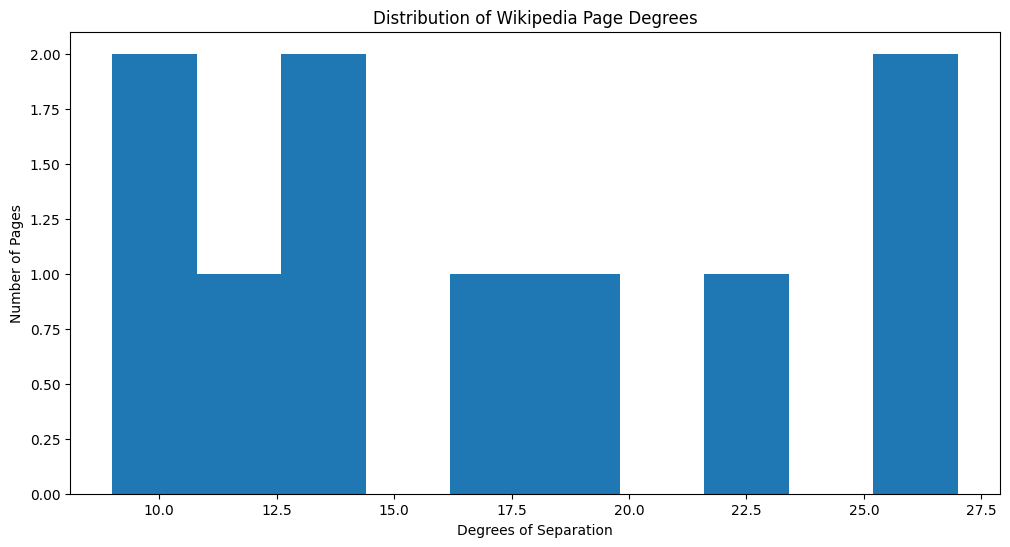

In [15]:
plt.figure(figsize=(12, 6))
plt.hist(degree_distribution.index)
plt.title("Distribution of Wikipedia Page Degrees")
plt.xlabel("Degrees of Separation")
plt.ylabel("Number of Pages")
plt.show()

In [16]:
print(f"\nMedian degree of separation: {median_degree}")
print(f"\nDegree distribution:")
print(degree_distribution)
print(f"\nPages with degree 6 in sample: {degree_6_count} ({degree_6_percentage:.2f}%)")
print(f"Estimated total Wikipedia pages with degree 6: {estimated_degree_6_total:,}")


Median degree of separation: 15.5

Degree distribution:
9     1
10    1
12    1
13    1
14    2
17    1
18    2
22    1
26    1
27    1
Name: degrees, dtype: int64

Pages with degree 6 in sample: 0 (0.00%)
Estimated total Wikipedia pages with degree 6: 0


## Cebuano Wikipedia

In [9]:
results = find_philosophy(start_url="https://ceb.wikipedia.org/wiki/Special:Random")
results

Loop detected!


('Chabet Kedour el Turki - Wikipedia', -1)